In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

from sklearn.metrics import roc_auc_score

In [2]:
df_clients = pd.read_csv('./data/clients.csv', index_col='client_id')
df_train = pd.read_csv('./data/uplift_train.csv', index_col='client_id')
df_test = pd.read_csv('./data/uplift_test.csv', index_col='client_id')

# Извлечение признаков
df_features = df_clients.copy()
df_features['first_issue_time'] = \
    (pd.to_datetime(df_features['first_issue_date'])
     - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_features['first_redeem_time'] = \
    (pd.to_datetime(df_features['first_redeem_date'])
     - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_features['issue_redeem_delay'] = df_features['first_redeem_time'] \
    - df_features['first_issue_time']
df_features = df_features.drop(['first_issue_date', 'first_redeem_date'], axis=1)

indices_train = df_train.index
indices_test = df_test.index
indices_learn, indices_valid = train_test_split(df_train.index, 
                                                test_size=0.4, 
                                                random_state=12)

In [3]:
df_features.head(5)

,age,gender,first_issue_time,first_redeem_time,issue_redeem_delay
client_id,,,,,
000012768d,45,U,1501947648,1.515094e+09,13146559.0
000036f903,72,F,1491832463,1.492951e+09,1118613.0
000048b7a6,68,F,1544880791,NaN,NaN
000073194a,60,F,1495544174,1.511522e+09,15978107.0
00007c7133,67,U,1495469828,1.546277e+09,50806825.0


### Task_1:

1.	Придумать новые признаки (у нас их всего 5 было) - сделать дополнительный feature engineering

In [4]:
df_features['issue_redeem_delay/age'] = df_features['issue_redeem_delay'] / df_features['age']

In [5]:
df_features.shape

(400162, 6)

In [6]:
df_features.isna().sum()

age                           0
gender                        0
first_issue_time              0
first_redeem_time         35469
issue_redeem_delay        35469
issue_redeem_delay/age    35469
dtype: int64

In [7]:
df_features.loc[df_features['first_issue_time'].isna(), 'first_issue_time'] = df_features['first_issue_time'].mean()
df_features.loc[df_features['issue_redeem_delay'].isna(), 'issue_redeem_delay'] = df_features['issue_redeem_delay'].mean()

df_features.loc[df_features['first_redeem_time'].isna(), 'first_redeem_time'] = df_features['first_issue_time'] +\
    df_features['first_issue_time']

df_features.loc[df_features['issue_redeem_delay/age'].isna(), 'issue_redeem_delay/age'] = df_features['issue_redeem_delay'] /\
    df_features['age']

Закодируем категориальный признак gender.

In [8]:
df_features = pd.concat([df_features, pd.get_dummies(df_features['gender'])], axis=1)
df_features.head(3)

,age,gender,first_issue_time,first_redeem_time,issue_redeem_delay,issue_redeem_delay/age,F,M,U
client_id,,,,,,,,,
000012768d,45,U,1.501948e+09,1.515094e+09,1.314656e+07,292145.755556,0,0,1
000036f903,72,F,1.491832e+09,1.492951e+09,1.118613e+06,15536.291667,1,0,0
000048b7a6,68,F,1.544881e+09,3.089762e+09,1.558871e+07,229245.771534,1,0,0


In [9]:
df_features.drop(columns=['gender', 'U'], inplace=True)
df_features.head(3)

,age,first_issue_time,first_redeem_time,issue_redeem_delay,issue_redeem_delay/age,F,M
client_id,,,,,,,
000012768d,45,1.501948e+09,1.515094e+09,1.314656e+07,292145.755556,0,0
000036f903,72,1.491832e+09,1.492951e+09,1.118613e+06,15536.291667,1,0
000048b7a6,68,1.544881e+09,3.089762e+09,1.558871e+07,229245.771534,1,0


In [10]:
df_features.dtypes

age                         int64
first_issue_time          float64
first_redeem_time         float64
issue_redeem_delay        float64
issue_redeem_delay/age    float64
F                           uint8
M                           uint8
dtype: object

In [11]:
df_features.isna().sum()

age                       0
first_issue_time          0
first_redeem_time         0
issue_redeem_delay        0
issue_redeem_delay/age    0
F                         0
M                         0
dtype: int64

In [12]:
df_features.loc[df_features['issue_redeem_delay/age'] == np.inf, 'issue_redeem_delay/age'] =\
    df_features['issue_redeem_delay/age'].mean() + df_features['issue_redeem_delay/age'].std() * 3

In [13]:
for column in range(df_features.shape[1]):
    print(column, df_features[df_features.columns[column]].sort_values(ascending=False)[0])

0 1901
1 1552686656.0
2 3105365552.0
3 81985199.0
4 57100543.0
5 1
6 1


In [14]:
df_features.isna().sum()

age                        0
first_issue_time           0
first_redeem_time          0
issue_redeem_delay         0
issue_redeem_delay/age    42
F                          0
M                          0
dtype: int64

In [15]:
df_features.loc[df_features['issue_redeem_delay/age'].isna(), 'issue_redeem_delay/age'] =\
    df_features['issue_redeem_delay/age'].mean() + df_features['issue_redeem_delay/age'].std() * 3

In [16]:
from sklearn.cluster import KMeans

inertia = []
clusters = []

for n_clusters in range(2,7):
    model = KMeans(n_clusters=n_clusters)

    model.fit(df_features[['age']])
    age_clusters_predictions = model.predict(df_features[['age']])

    clusters.append(n_clusters)
    inertia.append(model.inertia_)

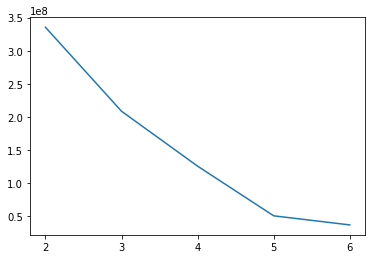

In [17]:
plt.plot([str(val) for val in clusters], inertia)

In [18]:
from sklearn.cluster import KMeans

inertia = []
clusters = []

for n_clusters in range(2,7):
    model = KMeans(n_clusters=n_clusters)

    model.fit(df_features[['age', 'F', 'M']])
    age_genderclusters_predictions = model.predict(df_features[['age', 'F', 'M']])

    clusters.append(n_clusters)
    inertia.append(model.inertia_)

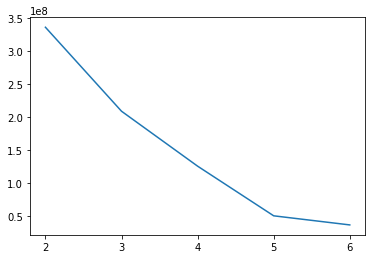

In [19]:
plt.plot([str(val) for val in clusters], inertia)

In [20]:
from sklearn.cluster import KMeans

inertia = []
clusters = []

for n_clusters in range(2,7):
    model = KMeans(n_clusters=n_clusters)

    model.fit(df_features)
    all_features_clusters_predictions = model.predict(df_features)

    clusters.append(n_clusters)
    inertia.append(model.inertia_)

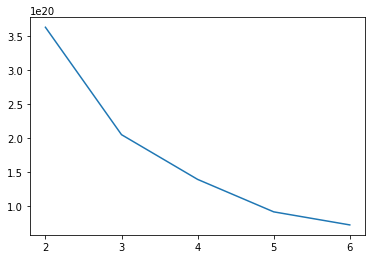

In [21]:
plt.plot([str(val) for val in clusters], inertia)

Для возраста и возраста + пола график выглядит похожим, возьму кластеризацию по возраст-пол, обоснованным выглядит кол-во кластеров: 5. Для кластеризации по всем признакам обоснованным выглядит кол-во кластеров: 3. Получу метки кластеров для этих значений, добавлю соответствующие признаки в датасет.

In [22]:
model = KMeans(n_clusters=5)
model.fit(df_features[['age', 'F', 'M']])
age_gender_clusters_predictions = model.predict(df_features[['age', 'F', 'M']])

age_gender_clusters_predictions[:10]

array([2, 0, 0, 0, 0, 2, 2, 2, 2, 2])

In [23]:
model = KMeans(n_clusters=3)
model.fit(df_features)
all_features_clusters_predictions = model.predict(df_features)

all_features_clusters_predictions[:10]

array([2, 2, 1, 2, 0, 0, 2, 2, 2, 0])

In [24]:
df_features['age_gender_clusters'] = age_gender_clusters_predictions
df_features['all_features_clusters'] = all_features_clusters_predictions

In [25]:
df_features.head(3)

,age,first_issue_time,first_redeem_time,issue_redeem_delay,issue_redeem_delay/age,F,M,age_gender_clusters,all_features_clusters
client_id,,,,,,,,,
000012768d,45,1.501948e+09,1.515094e+09,1.314656e+07,292145.755556,0,0,2,2
000036f903,72,1.491832e+09,1.492951e+09,1.118613e+06,15536.291667,1,0,0,2
000048b7a6,68,1.544881e+09,3.089762e+09,1.558871e+07,229245.771534,1,0,0,1


In [26]:
df_features = pd.concat([df_features, pd.get_dummies(df_features['age_gender_clusters'])], axis=1)
clusters = {}
for c in [0,1,2,3,4,5]:
    clusters[c] = f'age_gender_cluster_{c}'
print(clusters)    
df_features.rename(columns=clusters, inplace=True)

df_features = pd.concat([df_features, pd.get_dummies(df_features['all_features_clusters'])], axis=1)
clusters = {}
for c in [0,1,2,3]:
    clusters[c] = f'all_features_clusters_{c}'
print(clusters)
df_features.rename(columns=clusters, inplace=True)

df_features.drop(columns=['age_gender_cluster_0', 'all_features_clusters_0', 'age_gender_clusters', 'all_features_clusters'],
                 inplace=True)

df_features.head(3)

{0: 'age_gender_cluster_0', 1: 'age_gender_cluster_1', 2: 'age_gender_cluster_2', 3: 'age_gender_cluster_3', 4: 'age_gender_cluster_4', 5: 'age_gender_cluster_5'}
{0: 'all_features_clusters_0', 1: 'all_features_clusters_1', 2: 'all_features_clusters_2', 3: 'all_features_clusters_3'}


,age,first_issue_time,first_redeem_time,issue_redeem_delay,issue_redeem_delay/age,F,M,age_gender_cluster_1,age_gender_cluster_2,age_gender_cluster_3,age_gender_cluster_4,all_features_clusters_1,all_features_clusters_2
client_id,,,,,,,,,,,,,
000012768d,45,1.501948e+09,1.515094e+09,1.314656e+07,292145.755556,0,0,0,1,0,0,0,1
000036f903,72,1.491832e+09,1.492951e+09,1.118613e+06,15536.291667,1,0,0,0,0,0,0,1
000048b7a6,68,1.544881e+09,3.089762e+09,1.558871e+07,229245.771534,1,0,0,0,0,0,1,0


In [27]:
df_features.columns

Index(['age', 'first_issue_time', 'first_redeem_time', 'issue_redeem_delay',
       'issue_redeem_delay/age', 'F', 'M', 'age_gender_cluster_1',
       'age_gender_cluster_2', 'age_gender_cluster_3', 'age_gender_cluster_4',
       'all_features_clusters_1', 'all_features_clusters_2'],
      dtype='object')

### Task_2:

2.	Для подходов с одной моделью поварьировать параметры CatBoostClassifier либо даже попробовать другой алгоритм (опционально уже).

In [28]:
X_train = df_features.loc[indices_learn, :]
y_train = df_train.loc[indices_learn, 'target']
treat_train = df_train.loc[indices_learn, 'treatment_flg']

X_val = df_features.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'target']
treat_val =  df_train.loc[indices_valid, 'treatment_flg']

X_train_full = df_features.loc[indices_train, :]
y_train_full = df_train.loc[:, 'target']
treat_train_full = df_train.loc[:, 'treatment_flg']

X_test = df_features.loc[indices_test, :]

models_results = {
    'approach': [],
    'uplift@30%': [],
    'roc_auc': []
}

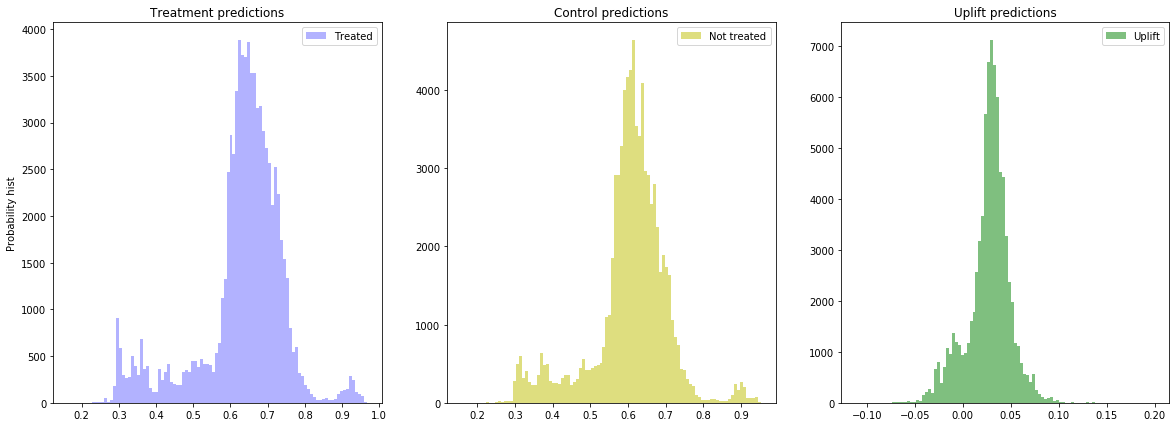

In [29]:
# Инструкция по установке пакета: https://github.com/maks-sh/scikit-uplift
# Ссылка на документацию: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier


sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train)#, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)
models_results['roc_auc'].append(roc_auc_score(y_val, uplift_sm))

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [30]:
models_results

{'approach': ['SoloModel'],
 'uplift@30%': [0.04621414588005279],
 'roc_auc': [0.5603308910583621]}

In [32]:
results = []

from random import choice

for iter_ in range(5):
    iterations = choice([5,10,20,30,50,75,100,150])
    learning_rate = choice([0.1,0.2,0.3,0.5,0.7])
    depth = choice([5,7,10,15])

    sm = SoloModel(CatBoostClassifier(iterations=iterations,
                                      thread_count=2, 
                                      learning_rate=learning_rate,
                                      depth=depth,
                                      random_state=42, silent=True))
    sm = sm.fit(X_train, y_train, treat_train)#, estimator_fit_params={'cat_features': cat_features})

    uplift_sm = sm.predict(X_val)

    sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)
    
    print(f'iterations: {iterations}, learning_rate: {learning_rate}, depth: {depth}, uplift@30%: {sm_score}')
    results.append((iterations, learning_rate, depth, sm_score))

KeyboardInterrupt: 

In [ ]:
results.sort(key=lambda param: param[-1], reverse=True)
results[:5]

### Task_3:

3.	Для пункта 2 (подходов на основе одной модели) вывести значимость признаков, основываясь на model.estimator.feature_importances_ и model.estimator.feature_names_.

In [33]:
sm = SoloModel(CatBoostClassifier(iterations=30,
                                      thread_count=2, 
                                      learning_rate=0.1,
                                      depth=10,
                                      random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train)
uplift_sm = sm.predict(X_val)

features_importances = list(zip(sm.estimator.feature_names_, sm.estimator.feature_importances_))
features_importances.sort(key=lambda param: param[1], reverse=True)
features_importances

[('first_redeem_time', 55.724590200444666),
 ('first_issue_time', 9.477738174677889),
 ('age', 8.087199404754521),
 ('treatment', 6.434735859422241),
 ('all_features_clusters_1', 6.301592289217304),
 ('issue_redeem_delay/age', 4.625627476723194),
 ('issue_redeem_delay', 3.8460519794248356),
 ('F', 2.2004098418833054),
 ('M', 1.9480437641444097),
 ('age_gender_cluster_2', 1.2877325842548244),
 ('all_features_clusters_2', 0.06534808915403495),
 ('age_gender_cluster_1', 0.0009303358987594737),
 ('age_gender_cluster_3', 0.0),
 ('age_gender_cluster_4', 0.0)]

### Task_4:

4.	Дополнить models_results дополнительными метриками (roc auc, logloss, f1). В конце вывести сводную таблицу всех показателей для всех подходов (как на основе

In [34]:
uplift_sm

array([0.07422721, 0.02101648, 0.05481111, ..., 0.03624461, 0.05829604,
       0.03926478])

In [35]:
roc_auc = roc_auc_score(y_val, uplift_sm)
# uplift_at_k_ = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)
uplift_at_k_ = uplift_at_k(y_true=y_val,
                                                                                   uplift=uplift_sm,
                                                                                   treatment=treat_val,
                                                                                   strategy='by_group', k=0.3)

roc_auc, uplift_at_k_

(0.5755153693441939, 0.0555941728308752)